## Meta

#### Settings:


In [57]:

start_over = False                                  # True will overwrite saved models with new models / False to Lock settings here.

amount_of_symbols_per_coin_pred = 6                 # Symbols to predict per coin.
aggregate_loss_history_epochs = 200                 # Calculate aggregated loss based on last X epochs

minimum_prediction_prob_trade = 0.90                # Minimum 90% prediciton probability before taking trade action. 
decrease_prob_trade_per_epoch_below_30_epochs = 0.01           # Decrease 1% every epoch.
decrease_prob_trade_per_epoch_above_30_epochs = 0.0025         # Decrease 0.25 % every epoch.

trade_when_below_loss = 0.35
binary_target_minimum_increase_min = 0.001          # Minimum 0.1 % increase.
upscale_to_maximum_data_point = 0.02                # Upscale all model input data to be in real range: -2% to 2%.

seconds_inbetween = 9                               # Seconds between handling training data.
seconds_inbetween_pibeline = 3                      # Seconds between cycling the pibeline.

pred_epoch = 20                                     # =  3   min    | Predict in how many epochs.
interval_columns = 100                              # = 15   min    | Amount of epochs in history per sample.
save_models_every_epochs = 300


is_google_colab = False
do_install_dependencies = False
datasets_dir = 'datasets'



real_wallet_dont_use_euro = 0

do_real_money_trade = True   # prod: True
do_training = True           # prod: True
do_gather_dataset = False    # prod: False
do_plots = True
do_training_verbose = False


use_models = {
    'NN': True,
    'CatBoost': False,
}



nn_learning_rate = 0.0000003
nn_batch_size = 200




# 12



### load_models:

In [58]:
def load_models():
    global models, model_name_for_trading

    if not exists(root_dir):
        os.mkdir(root_dir)
    if not exists(root_dir + '/' + datasets_dir):
        os.mkdir(root_dir + '/' + datasets_dir)

    if use_models["CatBoost"] == 1:
        model_name_for_trading = 'CatBoostAction'
        if not exists(root_dir + '/catboost'):
            os.mkdir(root_dir + '/catboost')

        for filename in os.listdir(root_dir + '/catboost/'):
            if 'ipynb_checkpoints' in filename:
                continue
            if filename not in models.keys():
                models[filename] = joblib.load(root_dir + '/catboost/' + filename)
                model_name_for_trading = filename

    if use_models["NN"] == 1:
        model_name_for_trading = 'NNAction'
        if not exists(root_dir + '/nn'):
            os.mkdir(root_dir + '/nn')
            
        for filename in os.listdir(root_dir + '/nn/'):
            if 'ipynb_checkpoints' in filename:
                continue
            if filename not in models.keys():
                models[filename] = tf.keras.models.load_model(root_dir + '/nn/' + filename)
                model_name_for_trading = filename


    models = sorted(models.items(), key=lambda x: x[0], reverse=False)
    models = {k: v for k, v in models}

    for model_name, _ in models.items():
        print('The holy ' + model_name + ' model has loaded!')

### create_models:

In [59]:
def create_models():
    global did_fit, do_predictions, losses_agregated, losses_agregated_positives, model_name_for_trading

    if len(models.keys()) == 0 or start_over:
        if use_models["NN"] == 1:
            model_name, model = create_model_nn('NNAction')
            models[model_name] = model
            losses_agregated[model_name] = []
            losses_agregated_positives[model_name] = []
            
            # model.summary()
            keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
            model_name_for_trading = model_name
            print(model_name + ' model created!')

        if use_models["CatBoost"] == 1:
            model_name, model = create_model_catboost('CatBoostAction')
            models[model_name] = model
            losses_agregated[model_name] = []
            losses_agregated_positives[model_name] = []
            model_name_for_trading = model_name
            print(model_name + ' model created!')

        did_fit = False
        do_predictions = False
    else:
        for model_name in models.keys():
            losses_agregated[model_name] = []
            losses_agregated_positives[model_name] = []


def create_model_nn(name):
    coin_input = keras.Input(batch_shape=(nn_batch_size, 1,), name = 'coin', dtype='string')
    symbol_input = keras.Input(batch_shape=(nn_batch_size, 1,), name = 'symbol', dtype='string')
    time_numbers_input = keras.Input(batch_shape=(nn_batch_size, interval_columns, 8), name = 'time_numbers_input')
    inputs = [
        coin_input,
        symbol_input,
        time_numbers_input
    ]

    normalizer = layers.StringLookup(vocabulary=list(avaiable_coins.keys()), output_mode='one_hot')
    coin = normalizer(coin_input)
    
    normalizer = layers.StringLookup(vocabulary=avaiable_symbols_list, output_mode='one_hot')
    symbol = normalizer(symbol_input)


    lstm = layers.LSTM(400, stateful = True, return_sequences = True)(time_numbers_input)
    lstm = layers.Dropout(0.3)(lstm)
    lstm = layers.LSTM(200, stateful = True, return_sequences = False)(lstm)
    lstm = layers.Dropout(0.3)(lstm)
    lstm = keras.Model(time_numbers_input, lstm)
    
    time_numbers_input_flattened = layers.Flatten()(time_numbers_input)
    dense = layers.concatenate([time_numbers_input_flattened, coin, symbol])
    dense = layers.Dense(400, activation = 'sigmoid', kernel_constraint = max_norm(5))(dense)
    dense = layers.Dropout(0.3)(dense)
    dense = layers.Dense(200, activation = 'sigmoid', kernel_constraint = max_norm(4))(dense)
    dense = layers.Dropout(0.3)(dense)
    dense = keras.Model(inputs, dense)
    
    main = layers.concatenate([lstm.output, dense.output])
    output = layers.Dense(1, activation = 'sigmoid')(main)


    model = keras.Model(inputs, output, name=name)
    model.compile(
        optimizer = keras.optimizers.Adam(
            learning_rate = nn_learning_rate
        ),
        loss = tf.keras.losses.BinaryCrossentropy(),
    )
    
    return name, model

def create_model_catboost(name):

    catboost_iterations = 7
    catboost_depth = 10
    catboost_learning_rate = 0.10
    catboost_one_hot_max_size = 0
    catboost_ctr_target_border_count = 50
    catboost_model_size_reg = 0
    catboost_max_ctr_complexity = 0
    catboost_l2_leaf_reg = None
    catboost_min_data_in_leaf = None
    catboost_random_strength = None
    catboost_bootstrap_type = 'Bernoulli'
    catboost_subsample = 0.5
    catboost_bagging_temperature = None

    param = {
        "iterations": catboost_iterations,
        "depth": catboost_depth,
        'learning_rate': catboost_learning_rate,
        "one_hot_max_size": catboost_one_hot_max_size,
        "ctr_target_border_count": catboost_ctr_target_border_count,
        "model_size_reg": catboost_model_size_reg,
        "max_ctr_complexity": catboost_max_ctr_complexity,
        'l2_leaf_reg': catboost_l2_leaf_reg,
        'min_data_in_leaf': catboost_min_data_in_leaf,
        'random_strength': catboost_random_strength,
        "bootstrap_type": catboost_bootstrap_type,

        "objective": "MultiClass",
        "allow_const_label": True,
        "task_type": "GPU", 
        "has_time": True, 
        "class_names": possible_labels,
        "random_state": 420,
        "allow_writing_files": False,
        "boosting_type": "Plain",
    }
    if catboost_bootstrap_type == "Bayesian":
        param["bagging_temperature"] = catboost_bagging_temperature
    elif catboost_bootstrap_type == "Bernoulli":
        param["subsample"] = catboost_subsample

    model = CatBoostClassifier(**param)

    return name, model
    

### populate_coins_to_pairs:

In [60]:
def validateActiveTickerSymbol(ticker):
    if float(ticker['lastPrice']) < 0.0000001 or float(ticker['bidPrice']) < 0.0000001 or float(ticker['askPrice']) < 0.0000001:
        return False
    return True
    
def populate_coins_to_pairs():
    global avaiable_coins, avaiable_symbols_list
    avaiable_coins = {}
    avaiable_symbols_list = []

    balances = binance.get_account()['balances']
    tickers = binance.get_ticker() # All symbol info


    for balance in balances:
        coin = balance['asset']
        avaiable_coins[coin] = []

    for ticker in tickers:
        if not validateActiveTickerSymbol(ticker):
            continue
        symbol = ticker['symbol']

        found = False
        for balance in balances:
            coin = balance['asset']
            if isCoinPairMatching(coin, symbol):
              avaiable_coins[coin].append(symbol)
              found = True
        if found:
            avaiable_symbols_list.append(symbol)

def isCoinPairMatching(coin, symbol):
    if coin not in symbol:
        return False
    
    symbols = ["BTCUP", "BTCDOWN", "ADAUP", "ADADOWN", "ETHUP", "ETHDOWN", "DOTUP", "DOTDOWN", "TRXUP", "TRXDOWN", "LINKUP", "LINKDOWN", \
                "BNBUP", "BNBDOWN", "CRH"]
    if any(x in symbol for x in symbols):
        return False

    if coin == 'AMB':
        similars = ["CREAMBUSD", "BEAM"]
        if any(x in symbol for x in similars):
            return False 
    elif coin == 'AUD':
        similars = ["AUDIO"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'TRU':
        similars = ["ASTRUSDT", "USDTRUB", "DOT"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'TUSD':
        similars = ["TUSDT"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'GAL':
        similars = ["GALA"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'BTC':
        similars = ["BTCST"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'OG':
        similars = ["DOGE", "OGN"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'COS':
        similars = ["COCOS"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'RUB':
        similars = ["TRUBTC"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'SHIB':
        similars = ["SUSHIBTC", "SUSHIBUSD", "SUSHIBNB"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'FET':
        similars = ["ELFETH"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'YFI':
        similars = ["YFII"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'TRB':
        similars = ["ASTRBTC", "ASTRBUSD"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'BAR':
        similars = ["HBAR"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'SC':
        similars = ["SCRT"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'REP':
        similars = ["DREP"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'GO':
        similars = ["AERGO", "ALGO", "DEGO"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'AST':
        similars = ["ASTR"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'AST':
        similars = ["CRVETH", "SSVETH"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'ONE':
        similars = ["AIONETH"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'GLM':
        similars = ["GLMR"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'DAR':
        similars = ["ADARUB"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'VET':
        similars = ["CRVETH", "SSVETH"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'OXT':
        similars = ["MBOXTRY"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'ACA':
        similars = ["ALPACA"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'ONT':
        similars = ["FRONT"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'TCT':
        similars = ["BTCTUSD", "BTTCTRY", "BTCTRY"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'AMP':
        similars = ["RAMP"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'WBTC':
        similars = ["FLOWBTC"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'LPT':
        similars = ["SLPTRY"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'PHA':
        similars = ["ALPHA"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'AVA':
        similars = ["KAVA", "AVAX"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'MOB':
        similars = ["TOMO"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'ORN':
        similars = ["TORN"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'OM':
        similars = ["OMG", "ATOM", "COMP", "LOOM", "TOMO", "PROM"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'AR':
        similars = ["ARDR", "ARK", "ARPA", "BAR", "FARM", "HARD", "HBAR", "NEAR", "RARE", "DAR", "SPARTA"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'ATA':
        similars = ["DATA"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'ANT':
        similars = ["SANTOS"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'WIN':
        similars = ["WING"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'BUSD':
        similars = ["BNBUSDC", "TRBUSDT", "MOBUSDT"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'OP':
        similars = ["PEOPLE"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'FOR':
        similars = ["FORTH"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'CKB':
        similars = ["DOCK", "QUICK"]
        if any(x in symbol for x in similars):
           return False
    elif coin in ['BETH', 'BDOT', 'T']:
        return False

    return True

### initBinanceInfo:

In [61]:
def initBinanceInfo():
    global binance_symbols

    get_exchange_info = binance.get_exchange_info()
    for symbol in get_exchange_info['symbols']:
        if symbol['symbol'] in avaiable_symbols_list:
            stepSize = 0
            stepSizeInteger = 0
            tickSize = 0
            minNotional = 0
            for filter in symbol['filters']:
                if filter['filterType'] == 'LOT_SIZE':
                    stepSize = float(filter['stepSize'])
                    if filter['stepSize'] == '0.10000000':
                        stepSizeInteger = 1
                    elif filter['stepSize'] == '0.01000000':
                        stepSizeInteger = 2
                    elif filter['stepSize'] == '0.00100000':
                        stepSizeInteger = 3
                    elif filter['stepSize'] == '0.00010000':
                        stepSizeInteger = 4
                    elif filter['stepSize'] == '0.00001000':
                        stepSizeInteger = 5
                    elif filter['stepSize'] == '0.00000100':
                        stepSizeInteger = 6
                    elif filter['stepSize'] == '0.00000010':
                        stepSizeInteger = 7
                    elif filter['stepSize'] == '0.00000001':
                        stepSizeInteger = 8
                elif filter['filterType'] == 'PRICE_FILTER':
                    if filter['tickSize'] == '0.10000000':
                        tickSize = 1
                    elif filter['tickSize'] == '0.01000000':
                        tickSize = 2
                    elif filter['tickSize'] == '0.00100000':
                        tickSize = 3
                    elif filter['tickSize'] == '0.00010000':
                        tickSize = 4
                    elif filter['tickSize'] == '0.00001000':
                        tickSize = 5
                    elif filter['tickSize'] == '0.00000100':
                        tickSize = 6
                    elif filter['tickSize'] == '0.00000010':
                        tickSize = 7
                    elif filter['tickSize'] == '0.00000001':
                        tickSize = 8
                elif filter['filterType'] == 'MIN_NOTIONAL':
                    minNotional = float(filter['minNotional'])

            binance_symbols[symbol['symbol']] = {
                'stepSize': stepSize,
                'stepSizeInteger': stepSizeInteger,
                'tickSize': tickSize,
                'minNotional': minNotional,
            }

### init_meta:

In [62]:
root_dir = 'models' 
categorial_features = ['symbol', 'coin']    # 'direction_', 

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    
    root_dir = 'drive/MyDrive/tradebot'

if is_google_colab or do_install_dependencies:
    !pip install catboost
    !pip install python-binance
    !pip install tensorflow

import os, psutil
from os.path import exists

from catboost import *
import joblib

import warnings
warnings.filterwarnings('ignore')

from binance import Client
from binance.enums import *

import sched, time
import pandas as pd

import time
from threading import Thread, Lock
import numpy as np

import fractions as frac
import math

import tensorflow as tf
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from tensorflow import keras
from keras import layers
from keras.models import *
from keras.layers import *
from keras.constraints import max_norm

import matplotlib.pyplot as plt

from IPython.display import clear_output

models = {}
categorial_features_indices = None
holding_coins = None
holding_coins_DEFAULT = {
    'balance': 0,
    'balance_eur': 1,
    'price': 0,
    'counting_epochs': 0,
    'symbol': '',
    'date': time.strftime("%H:%M:%S")
}
features_list = None
features_dtypes = None
avaiable_coins = None
avaiable_symbols_list = None

possible_labels = ['NONE']
for i in range(0, amount_of_symbols_per_coin_pred):
    possible_labels.append(str(i))

binance_api_key = 'AoVFfn3JvetSRHpffstx9tg0Zlmzc6WHeAdVjVUnLfbzOTslBanPUMFa7bP4CqtU'
binance_api_secret = 'zNGuMcE2UcycFQeVhTi5o9psM6GjZHvg7gEcTu1f8pazQg42EAMgvma5G583wv4G'
binance = Client(binance_api_key, binance_api_secret)

##### :
epoch, part_epoch, total_part_epochs = 1, 1, 0
memory_data = []
memory_symbols = {}
predictions_saved = []
deleted_symbol_data = 0
print_trained_string = '---'
loss_string = '-'
model_training_lock = None
model_df_buffer_lock = None
handleTickers_lock = None
model_saving_lock = None
binance_symbols = {} #
dont_update_holding_coins = []
dont_update_holding_coins_buffer = {}
cancel_orders = False
temp_tickers = {}
do_predictions = True
saved_df_buffer = pd.DataFrame()
saved_y_buffer = []
init_time = None
did_fit = True
losses_agregated = {}
losses_agregated_positives = {}
eur_balance_agregated = []
trades_history = []
median_loss = 1
median_loss_positives = 1
time_train = seconds_inbetween - 2
time_big = seconds_inbetween - 2
model_name_for_trading = ''
nn_epochs = 1  # Dynamic

In [ ]:
### NN:

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
preprocessor = make_column_transformer(
    (categorical_encoder, make_column_selector(dtype_include=object)),
    remainder="passthrough"
)

In [ ]:
populate_coins_to_pairs()
initBinanceInfo()
# create_models()

## Functions

### Init:

In [ ]:
def init():
    global holding_coins, do_predictions, model_training_lock, model_df_buffer_lock, \
    epoch, part_epoch, total_part_epochs, memory_data, memory_symbols, predictions_saved, \
    deleted_symbol_data, print_trained_string, loss_string, saved_y_buffer, \
    dont_update_holding_coins, dont_update_holding_coins_buffer, \
    cancel_orders, temp_tickers, saved_df_buffer, \
    handleTickers_lock, model_saving_lock, init_time

    initBinanceInfo()

    epoch, part_epoch, total_part_epochs = 1, 1, 0
    memory_data = []
    memory_symbols = {}
    predictions_saved = []
    deleted_symbol_data = 0
    print_trained_string = '---'
    loss_string = '-'
    model_training_lock = None
    model_df_buffer_lock = None
    handleTickers_lock = None
    dont_update_holding_coins = []
    dont_update_holding_coins_buffer = {}
    cancel_orders = False
    temp_tickers = {}
    do_predictions = True
    saved_df_buffer = pd.DataFrame()
    saved_y_buffer = []
    init_time = time.time()
    holding_coins = {}

    model_training_lock = Lock()
    model_df_buffer_lock = Lock()
    handleTickers_lock = Lock()
    model_saving_lock = Lock()

    print("""\
                        ._ o o
                        \_`-)|_
                      ,""       \ 
                    ,"  ## |   = ಠ. 
                  ," ##   ,-\__    `.
                ,"       /     `--._;)
              ,"     ## /
            ,"   ##    /
███████╗████████╗ ██████╗ ███╗   ██╗██╗  ██╗██████╗  ██████╗ ████████╗
██╔════╝╚══██╔══╝██╔═══██╗████╗  ██║██║ ██╔╝██╔══██╗██╔═══██╗╚══██╔══╝
███████╗   ██║   ██║   ██║██╔██╗ ██║█████╔╝ ██████╔╝██║   ██║   ██║   
╚════██║   ██║   ██║   ██║██║╚██╗██║██╔═██╗ ██╔══██╗██║   ██║   ██║   
███████║   ██║   ╚██████╔╝██║ ╚████║██║  ██╗██████╔╝╚██████╔╝   ██║   
╚══════╝   ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚═╝  ╚═╝╚═════╝  ╚═════╝    ╚═╝   v0.4
                                                                      
                    """)
    print()
    load_models()
    print()

### Runner:

In [ ]:
def runner():
    global schedule, epoch, part_epoch, total_part_epochs, init_time
    time_now = time.time()
    
    getTickers(part_epoch)

    if part_epoch == (seconds_inbetween / seconds_inbetween_pibeline) - 1:
        thread = Thread(target = updateBinanceBalances)
        thread.start()

    if seconds_inbetween / seconds_inbetween_pibeline <= part_epoch:
        processTickers()
        thread = Thread(target = handleTickers, args = (time_now, epoch, memory_symbols,))
        thread.start()
        epoch += 1
        part_epoch = 0
    part_epoch += 1
    total_part_epochs += 1
    # 459: 6 sec break..
    if total_part_epochs == 460:
        sleepy = (seconds_inbetween_pibeline * total_part_epochs) - (time.time() - init_time) - seconds_inbetween_pibeline + 2.5
        if sleepy < 0:
          sleepy = 0
        print('sleepy', sleepy)
        time.sleep(sleepy)
        init_time = time.time()
        total_part_epochs = 0
        return

    schedule.enter((seconds_inbetween_pibeline * total_part_epochs) - (time.time() - init_time) - seconds_inbetween_pibeline, 1, runner)
    schedule.run()

def getTickers(part_epoch):
  global temp_tickers

  try:
      tickers = binance.get_ticker() # All symbol info
  except:
      print('binance.get_ticker() FAILED 1/2.')
      try:
          tickers = binance.get_ticker() # All symbol info
      except:
          print('binance.get_ticker() FAILED 2/2.')
          return
  
  if part_epoch == 1:
      for symbol in tickers:
          if symbol['symbol'] not in avaiable_symbols_list:
              continue
          temp_tickers[symbol['symbol']] = {
              'bidPrice_low': float(symbol['bidPrice']),
              'bidPrice_high': float(symbol['bidPrice']),
              'askPrice_low': float(symbol['askPrice']),
              'askPrice_high': float(symbol['askPrice']),
              'volume': float(symbol['volume']),
              'quoteVolume': float(symbol['quoteVolume']),
              'tradeCount': int(symbol['count']),
              'lastPrice': float(symbol['lastPrice']),
          }
        
  else:
      for symbol in tickers:
          if symbol['symbol'] not in avaiable_symbols_list:
              continue
        
          new_bidPrice = float(symbol['bidPrice'])
          new_askPrice = float(symbol['askPrice'])
          
          temp_tickers[symbol['symbol']] = {
              'bidPrice_low': new_bidPrice if temp_tickers[symbol['symbol']]['bidPrice_low'] > new_bidPrice else temp_tickers[symbol['symbol']]['bidPrice_low'],
              'bidPrice_high': new_bidPrice if temp_tickers[symbol['symbol']]['bidPrice_high'] < new_bidPrice else temp_tickers[symbol['symbol']]['bidPrice_high'],
              'askPrice_low': new_askPrice if temp_tickers[symbol['symbol']]['askPrice_low'] > new_askPrice else temp_tickers[symbol['symbol']]['askPrice_low'],
              'askPrice_high': new_askPrice if temp_tickers[symbol['symbol']]['askPrice_high'] < new_askPrice else temp_tickers[symbol['symbol']]['askPrice_high'],
              'volume': float(symbol['volume']),
              'quoteVolume': float(symbol['quoteVolume']),
              'tradeCount': int(symbol['count']),
              'lastPrice': float(symbol['lastPrice']),
          }

def processTickers():
    global memory_symbols
    for symbol, values in temp_tickers.items():
        if symbol not in memory_symbols:
            memory_symbols[symbol] = {
                'bidPrice_low': [],
                'bidPrice_high': [],
                'askPrice_low': [],
                'askPrice_high': [],
                'volume': [],
                'quoteVolume': [],
                'tradeCount': [],
                'lastPrice': [],
            }
        memory_symbols[symbol]['bidPrice_low'].append(values['bidPrice_low'])
        memory_symbols[symbol]['bidPrice_high'].append(values['bidPrice_high'])
        memory_symbols[symbol]['askPrice_low'].append(values['askPrice_low'])
        memory_symbols[symbol]['askPrice_high'].append(values['askPrice_high'])
        memory_symbols[symbol]['volume'].append(values['volume'])
        memory_symbols[symbol]['quoteVolume'].append(values['quoteVolume'])
        memory_symbols[symbol]['tradeCount'].append(values['tradeCount'])
        memory_symbols[symbol]['lastPrice'].append(values['lastPrice'])


### MAIN Thread:

In [ ]:
def handleTickers(time_now_big, epoch, memory_symbols):
    global memory_data, deleted_symbol_data, print_trained_string, do_predictions, \
    predictions_saved, handleTickers_Lock, categorial_features_indices, features_dtypes, features_list, \
    time_big

    memory_data_symbol = None
    predictions_byModel = (
        {},
        '0',
    )
    
    handleTickers_lock.acquire() #
    if do_plots and epoch % 4 == 0:
        clear_output(wait=True)
    print('--------  Epoch: ', epoch, '  [' + str(time.strftime("%H:%M:%S")) + ']')
    print()

    # Proccess coin data
    proccessTickers_time = ''
    if epoch > 1:
        # Get list of symbols to check:
        use_symbols = []
        for coin in holding_coins.keys():
            use_symbols += avaiable_coins[coin]
            
        time_big_itcp = time.time() - time_now_big
        time_now = time.time()
        memory_data_symbol = proccessTickers(epoch, memory_symbols, True, use_symbols)
        proccessTickers_time = str(round(time_big_itcp, 2)) + ' + ' + str(round(time.time() - time_now, 2))

    # Balances and euro:
    print_eur_string = convert_wallet_to_euro(holding_coins, memory_symbols, epoch)
    print('[ ' + print_eur_string + ' ]   _ Balances:')
    for coin, inner in holding_coins.items():
        print(coin, str(round(inner['balance'], 4)), '', str(round(inner['balance_eur'], 2)) + ' €', '   |  Price: ' + str(inner['price']) + ' ' + inner['symbol'] + '  | Epoch: ' + str(inner['counting_epochs']) + '       [' + inner['date'] + ']')
    print()

    if epoch > pred_epoch:
        # Process Action Data
        time_now = time.time()
        saved, coins = processActionData(memory_data_symbol, True)
        proccessTickers_time += ' + ' + str(round(time.time() - time_now, 2))

        ## Init Set features_dtypes & categorial_features_indices ##
        if epoch == pred_epoch + 1:
            features_list = list(saved[0].keys())
            features_dtypes = {}
            categorial_features_indices = []
            i = 0
            for feature in features_list:
                if any(x in feature for x in categorial_features):
                    categorial_features_indices.append(i)
                i += 1
                if 'symbol' in feature or 'coin' in feature:    #  or 'direction_' in feature
                    features_dtypes[feature] = 'string'
                else:
                    features_dtypes[feature] = 'float32'
        ####

        if do_predictions and len(holding_coins.keys()) > 0:
            # Do Predictions:
            predictions_byModel = proccessPredictions(saved, coins)
    
    # Trade coins:
    if do_predictions and epoch > interval_columns + pred_epoch + 20:
        processTrading(predictions_byModel[0], epoch, memory_symbols)
    #

    # Now build data for the rest of the coins and symbols:
    if epoch > 1:
        time_now_proccessTickers = time.time()
        memory_data_symbol = proccessTickers(epoch, memory_symbols, False, None)
        proccessTickers_time += ' + pT:' + str(round(time.time() - time_now_proccessTickers, 2))

        # Start updating symbol priority list into avaiable_coins:
        thread = Thread(target = updateSymbolPriorityList, args = (memory_data_symbol,))
        thread.start()

    if epoch > pred_epoch:
        time_now_processActionData = time.time()
        memory_data.append(processActionData(memory_data_symbol, False)[0])
        proccessTickers_time += ' + pA:' + str(round(time.time() - time_now_processActionData, 2))
    #
    
    if epoch % pred_epoch == 0 and epoch > pred_epoch + interval_columns:
        do_predictions = True
        
    if epoch > pred_epoch:
        predictions_saved.append(predictions_byModel[0])

        if epoch == pred_epoch + 1:
            print('Attempting to create models now...')
            thread = Thread(target = create_models)
            thread.start()
        else:
            # Do Validation on Past predictions:
            training_list, y_train, validated_list_targets = validatePredictions(epoch, memory_symbols)
            if do_predictions and epoch > interval_columns:
                validatePastPredictions(validated_list_targets)
            
            if epoch == pred_epoch + interval_columns - 5:
                # Do warmup:
                print('Attempting to do warmup now...')
                thread = Thread(target = do_warmup, args = (training_list, y_train,))
                thread.start()

            elif epoch > pred_epoch + interval_columns:
                # Do training:
                thread = Thread(target = trainModels, args = (epoch, training_list, y_train,))
                thread.start()

                if do_plots and nn_epochs > 1 and epoch % 4 == 0 and len(holding_coins.keys()) > 0:
                    processPlotting(coins)
    

    # Cleanup:
    if epoch > interval_columns:
        for _, value in memory_symbols.items():
            del value['bidPrice_high'][0]
            del value['bidPrice_low'][0]
            del value['askPrice_high'][0]
            del value['askPrice_low'][0]
            del value['volume'][0]
            del value['quoteVolume'][0]
            del value['tradeCount'][0]
            del value['lastPrice'][0]
        deleted_symbol_data += 1
    if len(memory_data) == pred_epoch:
        del memory_data[0]
        del predictions_saved[0]

    for i in range(0, len(trades_history)):
        if trades_history[i]['x'] == 0:
            del trades_history[i]
            break
    for i in range(0, len(trades_history)):
        trades_history[i]['x'] -= 1
    

    if len(eur_balance_agregated) >= aggregate_loss_history_epochs:
        del eur_balance_agregated[0]
        
    ##
    time_big = round(time.time()-time_now_big, 2)
    print('---------------- ', total_part_epochs, '[', time_big, 's ==', 't: ' + proccessTickers_time, '| p:', predictions_byModel[1], ']', \
          ' || ', print_trained_string, '|  Loss:', loss_string, ' |  RAM:', round(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2), 'mb')
    print()
    print()
    
    handleTickers_lock.release()

### processPlotting():

In [ ]:
def processPlotting(coins):
    plt.figure(1)
    plt.subplots_adjust(hspace=0.3)
    fig = plt.gcf()
    fig.set_size_inches(20, 5)
    

    ### Loss plot:
    plt.subplot(211)
    ax = plt.gca()
    found = False
    
    for model_name, losses_agregat in losses_agregated.items():
        plt.plot(losses_agregat, label=model_name + ' Loss', marker='.', linestyle='-', color='b')
    for model_name, losses_agregat in losses_agregated_positives.items():
        if len(losses_agregat) > 0:
            found = True
            plt.plot(losses_agregat, label=model_name + ' Positives', marker='.', linestyle='--', color='orange')
    if found == False:
        return

    for trade in trades_history:
        if trade['x'] <= aggregate_loss_history_epochs - pred_epoch:
            ax.annotate(trade['text'], (trade['x'] + pred_epoch, 0.9), fontsize = 7)

    plt.axhline(y = 0.5, color = 'gray', linestyle = 'dotted')
    plt.title("Losses last " + str(aggregate_loss_history_epochs) + " epochs. Now: " + ' - '.join(coins))
    plt.ylabel('Loss', fontsize=8)
    plt.legend(loc='best')
    plt.ylim(0, 1)
    

    ### EUR profit plot:
    plt.subplot(212)
    ax = plt.gca()

    for trade in trades_history:
        ax.annotate(trade['text'], (trade['x'], trade['y']), fontsize = 7)

    if eur_balance_agregated[0] <= eur_balance_agregated[-1]:
        plt.plot(eur_balance_agregated, marker='.', linestyle='-', color='green')
    else:
        plt.plot(eur_balance_agregated, marker='.', linestyle='-', color='red')

    plt.title("EUR balance last " + str(aggregate_loss_history_epochs) + " epochs")
    plt.xlabel('Epoch', fontsize=8)
    plt.ylabel('EUR €', fontsize=8)


    plt.show()

### proccessTickers():

In [ ]:
def proccessTickers(epoch, memory_symbols, only_use_holding_symbols, use_symbols):
    global highest, lowest

    memory_data_symbol = {}

    for symbol, inner in memory_symbols.items():
        if only_use_holding_symbols and symbol not in use_symbols:
            continue

        dat = []

        temp_bidPrice_low = inner['bidPrice_low'][epoch - 1 - deleted_symbol_data]
        temp_bidPrice_high = inner['bidPrice_high'][epoch - 1 - deleted_symbol_data]
        temp_askPrice_low = inner['askPrice_low'][epoch - 1 - deleted_symbol_data]
        temp_askPrice_high = inner['askPrice_high'][epoch - 1 - deleted_symbol_data]
        temp_volume = inner['volume'][epoch - 1 - deleted_symbol_data]
        if temp_volume == 0:
            temp_volume = 0.0000001
        temp_quoteVolume = inner['quoteVolume'][epoch - 1 - deleted_symbol_data]
        if temp_quoteVolume == 0:
            temp_quoteVolume = 0.0000001
        temp_tradeCount = inner['tradeCount'][epoch - 1 - deleted_symbol_data]
        if temp_tradeCount == 0:
            temp_tradeCount = 0.0000001
        temp_lastPrice = inner['lastPrice'][epoch - 1 - deleted_symbol_data]
        if temp_lastPrice == 0:
            temp_lastPrice = 0.0000001


        for i in range(1, interval_columns + 1):
            if (epoch > i):
                index = epoch - i - 1 - deleted_symbol_data

                arr = []
                
                bidPrice_low = inner['bidPrice_low'][index] # Reverse + Pick i element.
                if bidPrice_low == 0:
                    arr.append(0)
                else:
                    bidPrice_low_change = (temp_bidPrice_low - bidPrice_low) / bidPrice_low
                    if bidPrice_low_change > upscale_to_maximum_data_point:
                        bidPrice_low_change = 1
                    elif bidPrice_low_change < -upscale_to_maximum_data_point:
                        bidPrice_low_change = -1
                    else:
                        bidPrice_low_change /= upscale_to_maximum_data_point
                    arr.append(bidPrice_low_change)
                    
                bidPrice_high = inner['bidPrice_high'][index] # Reverse + Pick i element.
                if bidPrice_high == 0:
                    arr.append(0)
                else:
                    bidPrice_high_change = (temp_bidPrice_high - bidPrice_high) / bidPrice_high
                    if bidPrice_high_change > upscale_to_maximum_data_point:
                        bidPrice_high_change = 1
                    elif bidPrice_high_change < -upscale_to_maximum_data_point:
                        bidPrice_high_change = -1
                    else:
                        bidPrice_high_change /= upscale_to_maximum_data_point
                    bidPrice_high_change /= upscale_to_maximum_data_point
                    arr.append(bidPrice_high_change)

                askPrice_low = inner['askPrice_low'][index] # Reverse + Pick i element.
                if askPrice_low == 0:
                    arr.append(0)
                else:
                    askPrice_low_change = (temp_askPrice_low - askPrice_low) / askPrice_low
                    if askPrice_low_change > upscale_to_maximum_data_point:
                        askPrice_low_change = 1
                    elif askPrice_low_change < -upscale_to_maximum_data_point:
                        askPrice_low_change = -1
                    else:
                        askPrice_low_change /= upscale_to_maximum_data_point
                    arr.append(askPrice_low_change)

                askPrice_high = inner['askPrice_high'][index] # Reverse + Pick i element.
                if askPrice_high == 0:
                    arr.append(0)
                else:
                    askPrice_high_change = (temp_askPrice_high - askPrice_high) / askPrice_high
                    if askPrice_high_change > upscale_to_maximum_data_point:
                        askPrice_high_change = 1
                    elif askPrice_high_change < -upscale_to_maximum_data_point:
                        askPrice_high_change = -1
                    else:
                        askPrice_high_change /= upscale_to_maximum_data_point
                    arr.append(askPrice_high_change)

                volume = inner['volume'][index] # Reverse + Pick i element.
                if volume == 0:
                    volume = 0.0000001
                volume_change = (temp_volume - volume) / volume
                if volume_change > upscale_to_maximum_data_point:
                    volume_change = 1
                elif volume_change < -upscale_to_maximum_data_point:
                    volume_change = -1
                else:
                    volume_change /= upscale_to_maximum_data_point
                arr.append(volume_change)

                quoteVolume = inner['quoteVolume'][index] # Reverse + Pick i element.
                if quoteVolume == 0:
                    quoteVolume = 0.0000001
                quoteVolume_change = (temp_quoteVolume - quoteVolume) / quoteVolume
                if quoteVolume_change > upscale_to_maximum_data_point:
                    quoteVolume_change = 1
                elif quoteVolume_change < -upscale_to_maximum_data_point:
                    quoteVolume_change = -1
                else:
                    quoteVolume_change /= upscale_to_maximum_data_point
                arr.append(quoteVolume_change)

                tradeCount = inner['tradeCount'][index] # Reverse + Pick i element.
                if tradeCount == 0:
                    tradeCount = 0.0000001
                tradeCount_change = (temp_tradeCount - tradeCount) / tradeCount
                if tradeCount_change > upscale_to_maximum_data_point:
                    tradeCount_change = 1
                elif tradeCount_change < -upscale_to_maximum_data_point:
                    tradeCount_change = -1
                else:
                    tradeCount_change /= upscale_to_maximum_data_point
                arr.append(tradeCount_change)

                lastPrice = inner['lastPrice'][index] # Reverse + Pick i element.
                if lastPrice == 0:
                    lastPrice = 0.0000001
                lastPrice_change = (temp_lastPrice - lastPrice) / lastPrice
                if lastPrice_change > upscale_to_maximum_data_point:
                    lastPrice_change = 1
                elif lastPrice_change < -upscale_to_maximum_data_point:
                    lastPrice_change = -1
                else:
                    lastPrice_change /= upscale_to_maximum_data_point
                arr.append(lastPrice_change)


                dat.insert(0, arr)


                temp_bidPrice_low = bidPrice_low
                temp_bidPrice_high = bidPrice_high
                temp_askPrice_low = askPrice_low
                temp_askPrice_high = askPrice_high
                temp_volume = volume
                temp_quoteVolume = quoteVolume
                temp_tradeCount = tradeCount
                temp_lastPrice = lastPrice

            else:
                dat.insert(0, [0, 0, 0, 0, 0, 0, 0, 0])
            

        memory_data_symbol[symbol] = dat

    return memory_data_symbol

### processActionData():

In [ ]:
def processActionData(memory_data_symbol, only_use_holding_symbols):
    global holding_coins, memory_data, categorial_features_indices, features_list, saved_df_buffer

    saved, coins = [], []

    if only_use_holding_symbols:
        for coin in list(holding_coins.keys()):
            for symbol in avaiable_coins[coin]:
                saved.append(getActionSampleRow(symbol, coin, memory_data_symbol))

            coins.append(coin)
    else:
        for coin in avaiable_coins.keys():
            for symbol in avaiable_coins[coin]:
                saved.append(getActionSampleRow(symbol, coin, memory_data_symbol))

            coins.append(coin)

    return saved, coins


def getActionSampleRow(symbol, coin, memory_data_symbol):
    data = {
        'coin': coin,
        'symbol': symbol,
        'time_numbers_input': []
    }

    if symbol.startswith(coin):
        for arr in memory_data_symbol[symbol]:
            arr_input = [x * -1 for x in arr]
            data['time_numbers_input'].append(arr_input)
    else:
        for arr in memory_data_symbol[symbol]:
            data['time_numbers_input'].append(arr)
    
    return data

### updateBinanceBalances + updateSymbolPriorityList:

In [ ]:
def updateBinanceBalances():
    global holding_coins, dont_update_holding_coins, cancel_orders

    if cancel_orders:
        cancel_orders = False
        orders = binance.get_open_orders()
        for order in orders:
            print('cancel_order:', binance.cancel_order(
                symbol = order['symbol'],
                orderId = order['orderId']))

    balances = binance.get_account()['balances']

    # ### DEBUG:
    # balances.append(
    #     {
    #         "asset": "DOGE",
    #         "free": "1000",
    # })
    # balances.append(
    #     {
    #         "asset": "EUR",
    #         "free": "440",
    # })

    found_assets = []
    for balance in balances:
        balance_number = float(balance['free'])
        if balance_number > 0.0001:
            if balance['asset'] not in holding_coins.keys():
                holding_coins[balance['asset']] = holding_coins_DEFAULT.copy()
            if balance['asset'] == 'EUR':
                balance_number -= real_wallet_dont_use_euro
                if balance_number < 1:
                    continue
            if balance['asset'] == 'BNB':
                balance_number -= 0.01  # 2.76eur 15.09.22
            if balance_number < 0.0001:
                continue
            if balance['asset'] not in dont_update_holding_coins:
                holding_coins[balance['asset']]['balance'] = balance_number
            found_assets.append(balance['asset'])
    
    for coin in list(holding_coins.keys()):
        if coin not in found_assets or holding_coins[coin]['balance_eur'] < 1:
            if coin in dont_update_holding_coins:
                dont_update_holding_coins.remove(coin)
                del dont_update_holding_coins_buffer[coin]
            del holding_coins[coin]

In [ ]:
def updateSymbolPriorityList(memory_data_symbol):
    global avaiable_coins

    symbol_changes = {}
    for symbol, details in memory_data_symbol.items():
        symbol_changes[symbol] = getPositiveChange(details[0][7]) # lastPrice
    symbol_changes = list(dict(sorted(symbol_changes.items(), key=lambda item: item[1], reverse = True)).keys())

    new_avaiable_coins = {}
    for coin, symbols in avaiable_coins.items():
        new_avaiable_coins[coin] = []
        for symbol in symbol_changes:
            if symbol in symbols:
                new_avaiable_coins[coin].append(symbol)

    avaiable_coins = new_avaiable_coins


def getPositiveChange(number):
    if number < 0:
        return number * -1
    else:
        return number

### proccessPredictions():

In [ ]:
def runModelPredictions(model_name, model, symbols, ds, list_data, coins):
    
    model_saving_lock.acquire()
  
    try:
        if model_name == 'NNAction':
            results = model.predict(ds, verbose = 0)
        elif model_name == 'CatBoostAction':
            results = model.predict_proba(list_data)
    except Exception as e:
        print('Model.Predict() Failed.')
        print(e)
        model_saving_lock.release()
        return {}

    model_saving_lock.release()

    predictions_byModel = {}

    i = 0
    for coin in coins:
        predictions_byModel[coin] = {}
        
        array = []
        found = 0

        for a in range(0, amount_of_symbols_per_coin_pred):
            if len(symbols) < i + 1:
                break
            if not symbols[i].startswith(coin) and not symbols[i].endswith(coin):
                break
            
            array.append(results[i][0])
            i += 1
            found += 1

        for b in range(found, amount_of_symbols_per_coin_pred):
            array.append(0)

        sorted_indices_array = np.argsort(array)[::-1][:amount_of_symbols_per_coin_pred] # highest first

        for a in range(0, found):
            predictions_byModel[coin][a] = {
                'symbol': symbols[i - found + sorted_indices_array[a]],
                'value': array[sorted_indices_array[a]],
            }
        
        for b in range(found, amount_of_symbols_per_coin_pred):
            predictions_byModel[coin][b] = {
                'symbol': '0',
                'value': 0,
            }
    
    return predictions_byModel

def proccessPredictions(saved, coins):
    time_now = time.time()
    
    list_data = {
        'coin': [],
        'symbol': [],
        'time_numbers_input': [],
    }
    predictions_byModel = {}

    coin_count = {}
    symbols = []
    total_predictions = 0
    
    for sample in saved:
        if sample['coin'] not in coin_count.keys():
            coin_count[sample['coin']] = 1
        elif coin_count[sample['coin']] >= amount_of_symbols_per_coin_pred:
            continue
        else:
            coin_count[sample['coin']] += 1

        # duplicate 42

        list_data['coin'].append(sample['coin'])
        list_data['symbol'].append(sample['symbol'])
        list_data['time_numbers_input'].append(sample['time_numbers_input'])

        # list_data.append(list(sample.values()))
        total_predictions += 1

        symbols.append(sample['symbol'])

    ds = clean_data_for_NN(list_data)

    for model_name, model in models.items():
        predictions_byModel[model_name] = runModelPredictions(model_name, model, symbols, ds, list_data, coins)

    pred_time = str(round(time.time() - time_now, 2)) + 's/' + str(total_predictions) + 'e'

    return predictions_byModel, pred_time

### validatePredictions:

In [ ]:
def validatePredictions(current_epoch, memory_symbols):
    global memory_data, predictions_saved
    
    list_data = {
        'coin': [],
        'symbol': [],
        'time_numbers_input': [],
    }
    y_train = []
    validated_list = {}
    validated_list_targets = {}

    for symbol, inner in memory_symbols.items():
        old_lastPrice = inner['lastPrice'][0]
        if old_lastPrice == 0:
            old_lastPrice = 0.0001
        new_lastPrice = inner['lastPrice'][current_epoch - 1 - deleted_symbol_data]

        validated_list[symbol] = (new_lastPrice - old_lastPrice) / old_lastPrice
        
    for sample in memory_data[0]:
        coin = sample['coin']
        symbol = sample['symbol']
        time_numbers_input = sample['time_numbers_input']

        if coin not in validated_list_targets.keys():
            validated_list_targets[coin] = []

        reg_target = validated_list[symbol]
        
        if symbol.startswith(coin):
            reg_target *= -1
            
        if reg_target > binary_target_minimum_increase_min * 3:
            y_result = 1
            validated_list_targets[coin].append(symbol)
        elif reg_target > binary_target_minimum_increase_min * 2:
            y_result = 0.9
            validated_list_targets[coin].append(symbol)
        elif reg_target > binary_target_minimum_increase_min:
            y_result = 0.8
            validated_list_targets[coin].append(symbol)
        elif reg_target > binary_target_minimum_increase_min / 2:
            y_result = 0.5
        elif reg_target > 0:
            y_result = 0.45
        else:
            y_result = 0

        # duplicate 43: for fitting

        list_data['coin'].append(coin)
        list_data['symbol'].append(symbol)
        list_data['time_numbers_input'].append(time_numbers_input)

        y_train.append(y_result)

    return list_data, y_train, validated_list_targets

In [ ]:
def validatePastPredictions(validated_list_targets):
    global loss_string, median_loss, median_loss_positives

    loss_string = ''

    for model_name, inner in predictions_saved[0].items():
        # Calculate Loss:
        losses, count = 0, 0
        losses_positives, count_positives = 0, 0

        print('_PAST:')
        for coin, detail in inner.items():
            symbols = ['NONE']
            for i in range(0, amount_of_symbols_per_coin_pred):
                if detail[i]['symbol'] == '0':
                    break
                symbols.append(detail[i]['symbol'])
            targets = validated_list_targets[coin]
            targets = list(filter(lambda x: x in symbols, targets))
            if len(targets) == 0:
                targets = ['NONE']

            pred_streng = ''
            for i in range(0, amount_of_symbols_per_coin_pred):
                if detail[i]['symbol'] == '0':
                    break
                pred_streng += detail[i]['symbol'] + ' ' + str(round(detail[i]['value'], 2)) + '    '

            print(coin, '_targets:', '  '.join(targets), '  ', '  ', '  ', '_pred:   ', pred_streng)
            
            found_positive = False
            loss, loss_positive = 0, 1

            if 'NONE' in targets:
                # Loss:
                loss = detail[0]['value']

                # Positives:
                if loss > 0.6:
                    loss_positive = loss
                    found_positive = True
            else:
                if detail[i]['symbol'] in targets:
                    loss = 1 - detail[0]['value']
                else:
                    loss = 0.5 + detail[0]['value']

                # divide_times = len(symbols) - 1
                # for i in range(0, len(symbols) - 1):
                #     if detail[i]['symbol'] in targets:
                #         # Loss:
                #         loss += 1 - detail[i]['value']
                #     else:
                #         loss += detail[i]['value']

                # loss /= divide_times
                loss_positive = loss
                found_positive = True
                
            if found_positive:
                count_positives += 1
                losses_positives += loss_positive
            count += 1
            losses += loss
        print()

        if count == 0:
            return
        
        losses /= count

        losses_agregated[model_name].append(losses)

        length_losses_agregated = len(losses_agregated[model_name])
        length_losses_agregated_positives = len(losses_agregated_positives[model_name])

        if count_positives > 0:
            losses_positives /= count_positives
        elif length_losses_agregated_positives > 0:
            losses_positives = losses_agregated_positives[model_name][length_losses_agregated_positives - 1]
        else:
            losses_positives = losses
        losses_agregated_positives[model_name].append(losses_positives)
        length_losses_agregated_positives += 1

        if length_losses_agregated > aggregate_loss_history_epochs:
            length_losses_agregated -= 1
            del losses_agregated[model_name][0]

        if length_losses_agregated_positives > aggregate_loss_history_epochs:
            length_losses_agregated_positives -= 1
            del losses_agregated_positives[model_name][0]
        
        median_loss = round(sum(losses_agregated[model_name]) / length_losses_agregated, 3)
        median_loss_positives = round(sum(losses_agregated_positives[model_name]) / length_losses_agregated_positives, 3)

        loss_string += str(median_loss) + ' (P: ' + str(median_loss_positives) + ' )  '
        #

### convert_wallet_to_euro():

In [ ]:
def convert_wallet_to_euro(holding_coins, memory_symbols, epoch):
    global dont_update_holding_coins, dont_update_holding_coins_buffer, eur_balance_agregated

    euro = 0

    for coin, data in holding_coins.items():
        found = False
        if coin == 'EUR':
            euro += data['balance']
            holding_coins[coin]['balance_eur'] = data['balance']
            found = True
            continue
        
        for symbol, inner in memory_symbols.items():
            if symbol in avaiable_coins[coin] and 'EUR' in symbol:
                balance = 0
                if symbol.endswith(coin):
                    price = (inner['askPrice_high'][epoch - 1 - deleted_symbol_data] + inner['askPrice_low'][epoch - 1 - deleted_symbol_data]) / 2
                    balance = data['balance'] / price
                else:
                    price = (inner['bidPrice_high'][epoch - 1 - deleted_symbol_data] + inner['bidPrice_low'][epoch - 1 - deleted_symbol_data]) / 2
                    balance = data['balance'] * price
                    
                euro += balance
                holding_coins[coin]['balance_eur'] = balance
                found = True
                break
        else:
            for symbol in avaiable_coins[coin]:
                similars = ["BTC", "ETH", "BNB", "USDT", "BUSD"]
                if any(x in symbol for x in similars):
                    new_currency = 0
                    if symbol.endswith(coin):
                        price = (memory_symbols[symbol]['askPrice_high'][epoch - 1 - deleted_symbol_data] + memory_symbols[symbol]['askPrice_low'][epoch - 1 - deleted_symbol_data]) / 2
                        new_currency = data['balance'] / price
                    else:
                        price = (memory_symbols[symbol]['bidPrice_high'][epoch - 1 - deleted_symbol_data] + memory_symbols[symbol]['bidPrice_low'][epoch - 1 - deleted_symbol_data]) / 2
                        new_currency = data['balance'] * price
                    new_coin = symbol.replace(coin, '')
                    
                    # print(symbol, coin, new_coin) 
                    for symbol2 in memory_symbols.keys():
                        if new_coin in avaiable_coins.keys():
                            if symbol2 in avaiable_coins[new_coin] and 'EUR' in symbol2:
                                balance = 0
                                if symbol2.endswith(coin):
                                    price = (memory_symbols[symbol2]['askPrice_high'][epoch - 1 - deleted_symbol_data] + memory_symbols[symbol2]['askPrice_low'][epoch - 1 - deleted_symbol_data]) / 2
                                    balance = new_currency / price
                                else:
                                    price = (memory_symbols[symbol2]['bidPrice_high'][epoch - 1 - deleted_symbol_data] + memory_symbols[symbol2]['bidPrice_low'][epoch - 1 - deleted_symbol_data]) / 2
                                    balance = new_currency * price
                                    
                                euro += balance
                                holding_coins[coin]['balance_eur'] = balance
                                found = True
                                break
                    else:
                        continue
                    break

        if found == False:            
          print('ALEED!!: convert_wallet_to_euro() | Couldnt resolve coin for trading euro:', coin)

    # Cleanup low balances:
    for coin in list(holding_coins.keys()):
        if holding_coins[coin]['balance_eur'] < 2:
            euro -= holding_coins[coin]['balance_eur']
            del holding_coins[coin]

    # For EUR profit plot:
    eur_balance_agregated.append(euro)

    return str(round(euro, 2)) + ' €'

### processTrading:

In [ ]:
def processTrading(predictions_byModel, current_epoch, memory_symbols):
    global holding_coins, dont_update_holding_coins, dont_update_holding_coins_buffer, cancel_orders

    coin_list = list(holding_coins.keys())
    coins_minimum_limit = {}

    for coin in coin_list:
        if holding_coins[coin]['counting_epochs'] < 30:
            coins_minimum_limit[coin] = minimum_prediction_prob_trade - (decrease_prob_trade_per_epoch_below_30_epochs * holding_coins[coin]['counting_epochs'])
        else:
            counting_epochs = holding_coins[coin]['counting_epochs'] - 30
            coins_minimum_limit[coin] = minimum_prediction_prob_trade - 0.3 - (decrease_prob_trade_per_epoch_above_30_epochs * counting_epochs)

    print('_TRADING:')
    for inner in predictions_byModel.values():
        for coin, details in inner.items():
            if coin in holding_coins.keys():
                print(coin, details[0]['symbol'], str(round(details[0]['value'] * 100, 2)) + '%', '  ', '(>', str(round(100 * coins_minimum_limit[coin], 1)) + '%)')
    print()

    for coin in coin_list:
        if coin not in predictions_byModel[model_name_for_trading].keys():
            continue
        if median_loss > trade_when_below_loss:
            continue
        if predictions_byModel[model_name_for_trading][coin][0]['value'] < coins_minimum_limit[coin]:
            continue

        symbol = predictions_byModel[model_name_for_trading][coin][0]['symbol']
        buying_coin = symbol.replace(coin, '')

        buying_quantity = None
        price = None

        if symbol.startswith(coin):
            bidPrice_low = memory_symbols[symbol]['bidPrice_low'][current_epoch - 1 - deleted_symbol_data]
            price = bidPrice_low
            buying_quantity = holding_coins[coin]['balance'] * price
        else:
            askPrice_high = memory_symbols[symbol]['askPrice_high'][current_epoch - 1 - deleted_symbol_data]
            price = askPrice_high
            buying_quantity = holding_coins[coin]['balance'] / price

        price = round_down(price, int(binance_symbols[symbol]['tickSize']))
        buying_quantity = round_down(buying_quantity, 7)


        trade = '--> Attempt Trading ' + str(holding_coins[coin]['balance']) + ' ' + coin + ' to ' + str(buying_quantity) + ' ' + buying_coin + \
                ' for ' + str(price) + '        [' + time.strftime("%H:%M:%S") + ']'
        print(trade)

        trades_history.append({
            'text': coin + '->' + buying_coin,
            'x': len(eur_balance_agregated) - 1,
            'y': eur_balance_agregated[-1],
        })


        if do_real_money_trade:
            #########################################################
            #########################################################
            #########################################################
              
            side = SIDE_BUY
            order_quantity = buying_quantity
            order_notional = holding_coins[coin]['balance']
            if symbol.endswith(buying_coin):
                side = SIDE_SELL
                order_quantity = holding_coins[coin]['balance']
                order_notional = buying_quantity

            order_quantity = round_down(order_quantity, int(binance_symbols[symbol]['stepSizeInteger']))

            if binance_symbols[symbol]['minNotional'] >= order_notional:
                print('minNotional err', coin, binance_symbols[symbol]['minNotional'], order_quantity)
                del holding_coins[coin]
                if coin in dont_update_holding_coins:
                    dont_update_holding_coins.remove(coin)
                    del dont_update_holding_coins_buffer[coin]
                print(coin + ' deleted from trading wallet.')
                continue

            limit_price = format(price, '.' + str(binance_symbols[symbol]['tickSize']) + 'f')
            order_quantity = format(order_quantity, '.' + str(binance_symbols[symbol]['stepSizeInteger']) + 'f')

            print(symbol, side, order_quantity, limit_price)
        
            success = False
            try:
                cancel_orders = True
                order = binance.create_order(
                    symbol=symbol,
                    side=side,
                    type=ORDER_TYPE_LIMIT,
                    timeInForce=TIME_IN_FORCE_GTC,
                    quantity=order_quantity,
                    price=limit_price)
                print(order)
                success = True
            except Exception as e:
                print('create_order err:', e.message)
                if 'insufficient balance' in e.message or 'MIN_NOTIONAL' in e.message:
                    if coin not in dont_update_holding_coins:
                        if coin not in dont_update_holding_coins_buffer.keys():
                            dont_update_holding_coins_buffer[coin] = 1
                        else:
                            dont_update_holding_coins_buffer[coin] += 1
                            if dont_update_holding_coins_buffer[coin] > 2:
                                dont_update_holding_coins.append(coin)
                    else:
                        holding_coins[coin]['balance'] -= binance_symbols[symbol]['stepSize']
            ###
            ########################################################

            if success:
                balance = buying_quantity
                if buying_coin in holding_coins.keys():
                    balance += holding_coins[buying_coin]['balance']

                # Set the new acquired coin:
                holding_coins[buying_coin] = {
                    'balance': balance,
                    'balance_eur': 1, 
                    'price': limit_price,
                    'counting_epochs': 0,
                    'symbol': symbol, 
                    'date': time.strftime('%H:%M:%S')
                }

                del holding_coins[coin]

                if coin in dont_update_holding_coins:
                    dont_update_holding_coins.remove(coin)
                    del dont_update_holding_coins_buffer[coin]
                    
            print()

    if median_loss < trade_when_below_loss:
        for coin in holding_coins.keys():
            holding_coins[coin]['counting_epochs'] += 1

In [ ]:
def round_down(value, decimals):
    factor = 10 ** decimals
    f = frac.Fraction(value)
    return float(frac.Fraction(math.floor(f * factor),  factor))

### trainModels:

In [ ]:
def clean_data_for_NN(training_list, y_train = None):
    if y_train != None:

        len_data = len(y_train)

        training_list['coin'] = np.array(training_list['coin'], dtype = 'object')
        training_list['coin'] = np.reshape(training_list['coin'], (len_data, 1))

        training_list['symbol'] = np.array(training_list['symbol'], dtype = 'object')
        training_list['symbol'] = np.reshape(training_list['symbol'], (len_data, 1))

        training_list['time_numbers_input'] = np.array(training_list['time_numbers_input'], dtype = 'float32')
        training_list['time_numbers_input'] = np.reshape(training_list['time_numbers_input'], (len_data, interval_columns, 8))

        y_train = np.array(y_train, dtype = 'float32')
        y_train = np.reshape(y_train, (len_data, 1))

        train_ds = tf.data.Dataset.from_tensor_slices((training_list, y_train))
        train_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size = nn_batch_size, count = nn_batch_size - 1))
        train_ds = train_ds.batch(nn_batch_size, drop_remainder = True)
        
        return train_ds
    
    else:

        len_data = len(training_list['coin'])

        training_list['coin'] = np.array(training_list['coin'], dtype = 'object')
        training_list['coin'] = np.reshape(training_list['coin'], (len_data, 1))

        training_list['symbol'] = np.array(training_list['symbol'], dtype = 'object')
        training_list['symbol'] = np.reshape(training_list['symbol'], (len_data, 1))

        training_list['time_numbers_input'] = np.array(training_list['time_numbers_input'], dtype = 'float32')
        training_list['time_numbers_input'] = np.reshape(training_list['time_numbers_input'], (len_data, interval_columns, 8))

        train_ds = tf.data.Dataset.from_tensor_slices(training_list)
        train_ds = train_ds.repeat(nn_batch_size)
        train_ds = train_ds.batch(nn_batch_size, drop_remainder = True)

        return train_ds


def do_warmup(training_list, y_train):

    if use_models["NN"] == 1:
        time_now = time.time()
        print(0)
        model_name, model = create_model_nn('NNAction')
        print(1, time.time() - time_now)
        time_now = time.time()
        training_ds = clean_data_for_NN(training_list, y_train)
        print(2, time.time() - time_now)
        time_now = time.time()
        model.fit(training_ds,
                epochs = nn_epochs,
                verbose = 1)
        print(model_name, 'Did warmup fit:', time.time() - time_now)

    if use_models["CatBoost"] == 1:
        time_now = time.time()
        print(0)
        _, model = create_model_catboost('CatBoostAction')
        print(1)
        df = pd.DataFrame(training_list)
        print(2)
        model.fit(df, 
                y_train, 
                cat_features = categorial_features_indices, 
                verbose = True)
        print(model_name, 'Did warmup:', time.time() - time_now)

In [ ]:
def trainModels(epoch, training_list, y_train):
    global print_trained_string, saved_df_buffer, saved_y_buffer, time_train, nn_epochs

    time_now = time.time()

    if do_gather_dataset or use_models["CatBoost"] == 1:
        df = pd.DataFrame(training_list)
        df = df.astype(dtype = features_dtypes)

        if do_gather_dataset:
            model_df_buffer_lock.acquire()
            saved_df_buffer = pd.concat([saved_df_buffer, df])
            saved_y_buffer += y_train
            model_df_buffer_lock.release()

    model_training_lock.acquire()
    time_now = time.time()

    if time_train < seconds_inbetween - 1 and time_big < seconds_inbetween - 1:
        nn_epochs += 1
    elif (time_train > seconds_inbetween - 0.5 or time_big > seconds_inbetween - 0.5) and nn_epochs > 1:
        nn_epochs -= 1

    if do_training and nn_epochs > 0:

        if use_models["NN"] == 1:
            training_ds = clean_data_for_NN(training_list, y_train)
            for model_name, model in models.items():
                if "NN" in model_name:
                    model.fit(training_ds,
                            epochs = nn_epochs,
                            verbose = do_training_verbose)
        if use_models["CatBoost"] == 1:
            for model_name, model in models.items():
                if "CatBoost" in model_name:
                    model.fit(df, 
                            y_train, 
                            cat_features = categorial_features_indices, 
                            verbose = do_training_verbose)

        if epoch % save_models_every_epochs == 0:
            model_saving_lock.acquire()
            save() # Save models
            model_saving_lock.release()
            print('Models saved.')

    time_train = time.time() - time_now

    model_training_lock.release()

    print_trained_string = '[Trained ' + str(len(y_train)) + ' [' + str(round(time_train, 2)) + ' s]  ' + str(nn_epochs) + ' epochs ]'

### save:

In [ ]:
def save():
    global saved_df_buffer, saved_y_buffer
    time_now = time.time()

    if do_training:
        for model_name, model in models.items():
            if "NN" in model_name and use_models["NN"] == 1:
                try:
                    model.save(root_dir + '/nn/' + model_name)
                except Exception as e:
                    print('SAVE FAILED:', model_name)
                    print(e)
            if "CatBoost" in model_name and use_models["CatBoost"] == 1:
                joblib.dump(model, root_dir + '/catboost/' + model_name)

    if do_gather_dataset:
        if model_df_buffer_lock.locked():
            model_df_buffer_lock.acquire() #
            saved_df_buffer = pd.DataFrame()
            saved_y_buffer = []
            model_df_buffer_lock.release() #
            print('Aborted save df.', round(time.time() - time_now, 2), 's')
        else:
            time_string = str(round(time.time()))
            model_df_buffer_lock.acquire() #
            df_import = saved_df_buffer
            saved_df_buffer = pd.DataFrame()
            y_import = saved_y_buffer
            saved_y_buffer = []
            model_df_buffer_lock.release() #
            df_import.to_csv(root_dir + '/' + datasets_dir + '/' + time_string + '.csv', index = False)
            joblib.dump(y_import, root_dir + '/' + datasets_dir + '/' + time_string + '.csv.y')
            print('Saved df to', datasets_dir, '. ', round(time.time() - time_now, 2), 's', '', len(df_import.index), len(y_import))

        print()

## Main

In [ ]:
# save()

INFO:tensorflow:Assets written to: models/nn/NNAction\assets


INFO:tensorflow:Assets written to: models/nn/NNAction\assets


--------  Epoch:  3708   [01:03:38]

[ 11.7 € ]   _ Balances:
PSG 1.69  11.7 €    |  Price: 6.48 PSGBUSD  | Epoch: 23       [01:00:09]

_TRADING:
PSG PSGUSDT 1.83%    (> 67.0%)

_PAST:
PSG _targets: NONE          _pred:    PSGBTC 0.01    PSGUSDT 0.01    PSGBUSD 0.01    



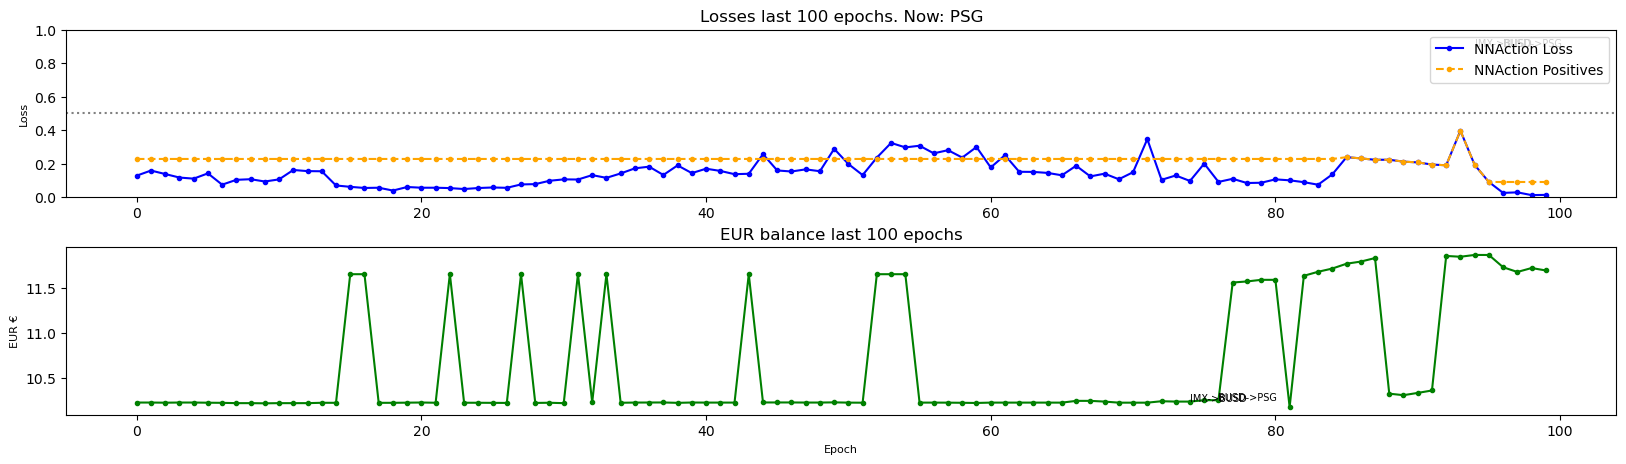

----------------  86 [ 10.37 s == t: 4.64 + 0.48 + 0.0 + pT:0.62 + pA:0.38 | p: 0.55s/3e ]  ||  [Trained 2960 [8.04 s]  3 epochs ] |  Loss: 0.144 (P: 0.221 )    |  RAM: 3651 mb


--------  Epoch:  3709   [01:03:45]

[ 11.63 € ]   _ Balances:
PSG 1.69  11.63 €    |  Price: 6.48 PSGBUSD  | Epoch: 24       [01:00:09]

_TRADING:
PSG PSGUSDT 17.76%    (> 66.0%)

_PAST:
PSG _targets: NONE          _pred:    PSGBTC 0.01    PSGUSDT 0.01    PSGBUSD 0.01    

----------------  88 [ 3.46 s == t: 1.77 + 0.0 + 0.0 + pT:0.42 + pA:0.26 | p: 0.99s/3e ]  ||  [Trained 2960 [8.04 s]  3 epochs ] |  Loss: 0.143 (P: 0.22 )    |  RAM: 3644 mb


--------  Epoch:  3710   [01:03:52]

[ 11.59 € ]   _ Balances:
PSG 1.69  11.59 €    |  Price: 6.48 PSGBUSD  | Epoch: 25       [01:00:09]

_TRADING:
PSG PSGUSDT 42.82%    (> 65.0%)



Exception in thread Thread-23229:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connectionpool.py", line 386, in _m

_PAST:
PSG _targets: NONE          _pred:    PSGBTC 0.0    PSGUSDT 0.0    PSGBUSD 0.0    

----------------  90 [ 3.34 s == t: 1.0 + 0.33 + 0.0 + pT:0.47 + pA:0.31 | p: 1.19s/3e ]  ||  [Trained 2960 [11.75 s]  3 epochs ] |  Loss: 0.142 (P: 0.219 )    |  RAM: 3644 mb


binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.
--------  Epoch:  3711   [01:04:16]

binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.


Exception in thread Thread-23239:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connectionpool.py", line 386, in _m

[ 10.13 € ]   _ Balances:
PSG 1.69  10.13 €    |  Price: 6.48 PSGBUSD  | Epoch: 26       [01:00:09]

binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.
binance.get_ticker() FAILED 1/2.


Exception in thread Thread-23238:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connectionpool.py", line 386, in _m

_TRADING:
PSG PSGUSDT 67.52%    (> 64.0%)

--> Attempt Trading 1.69 PSG to 10.7990999 USDT for 6.38        [01:04:17]
PSGUSDT SELL 1.68 6.38
binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.


Exception in thread Thread-23243:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connectionpool.py", line 386, in _m

binance.get_ticker() FAILED 1/2.


Exception in thread Thread-23275:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connectionpool.py", line 386, in _m

binance.get_ticker() FAILED 2/2.
binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.
binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.
binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.
binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.
binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.
binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.
binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.
binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.


Exception in thread Thread-23283:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "c:\ProgramData\Anaconda3\envs\py39gpu\lib\site-packages\urllib3\connectionpool.py", line 386, in _m

binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.
binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.
binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.
binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.
binance.get_ticker() FAILED 1/2.
binance.get_ticker() FAILED 2/2.


KeyboardInterrupt: 

In [ ]:
init()
schedule = sched.scheduler(time.time, time.sleep)
while(1):
    runner()
    print('Next episode')


# Last folder size: 29.1mb

# TODO:
# Add volatility indicator per coin/symbol 
#
